### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images


**Note:** This notebook uses the Mesmer algorithm, which has a more restrictive [license](https://github.com/vanvalenlab/deepcell-tf/blob/master/LICENSE) than the rest of the codebase

In [1]:
# import required packages
import os
import warnings
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from alpineer import io_utils
from skimage import io
from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import deepcell_service_utils, example_dataset, plot_utils

## 0: Set root directory and download example dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change `base_dir` to point to your own sub-directory within the data folder.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [2]:
# set up the base directory
base_dir = "../data/LN_2006N3R3"

## 1: set file paths and parameters

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [3]:
# set up file paths
tiff_dir = os.path.join(base_dir, "image_data")
cell_table_dir = os.path.join(base_dir, "segmentation/cell_table")
deepcell_input_dir = os.path.join(base_dir, "segmentation/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation/deepcell_output")
deepcell_visualization_dir = os.path.join(base_dir, "segmentation/deepcell_visualization")

In [4]:
# create directories if do not exist
for directory in [tiff_dir, cell_table_dir, deepcell_input_dir, deepcell_output_dir, deepcell_visualization_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
def tile(input_folder, output_folder_base):
    
    files = os.listdir(input_folder)
    filename = os.path.join(input_folder, files[0])
    image = Image.open(filename)
    print(f"Using {filename} for image dimensions.")
    img_width, img_height = image.size
    print(f"Image width: {img_width} Image height: {img_height}")
        
    opt_tile_width = None
    opt_tile_height = None
    
    tile_dim = list(range(1500, 2041))
    for tile_dim in list(reversed(tile_dim)):
        if img_width % tile_dim == 0:
            opt_tile_width = tile_dim            
    if opt_tile_width:
        num_tiles_width = img_width // opt_tile_width
        print(f"Number of tiles, width: {num_tiles_width} {opt_tile_width}")
        new_width=img_width
    else:
        print("No optimal tile width between 1800-2040, finding optimal width to crop image.")
        new_width = list(range(img_width-100, img_width))
        for new_width in list(reversed(new_width)):
            tile_dim = list(range(1800, 2041))
            for tile_dim in list(reversed(tile_dim)):
                if new_width % tile_dim == 0:
                    opt_tile_width = tile_dim
                    num_tiles_width = new_width // opt_tile_width
                    break
            if opt_tile_width:
                break
        print(f"New image width: {new_width}")
        print(f"Number of tiles, width: {num_tiles_width} {opt_tile_width}")
                    
       
    tile_dim = list(range(1800, 2041))       
    for tile_dim in list(reversed(tile_dim)):
            if img_height % tile_dim == 0:
                opt_tile_height = tile_dim
    if opt_tile_height:
        num_tiles_height = img_height // opt_tile_height
        print(f"Number of tiles, height: {num_tiles_height} {opt_tile_height}")
        new_height=img_height
        
    else:
        print("No optimal tile height between 1800-2040, finding optimal height to crop image.")
        new_height = list(range(img_height-10, img_height))
        for new_height in list(reversed(new_height)):
            tile_dim = list(range(1800, 2041))
            for tile_dim in list(reversed(tile_dim)):
                if new_height % tile_dim == 0:
                    opt_tile_height = tile_dim
                    num_tiles_height = new_height // opt_tile_height
                    break
            if opt_tile_height:
                break
                
        print(f"New image height: {new_height}")
        print(f"Number of tiles, height: {num_tiles_height} {opt_tile_height}")
        
    for filename in files:
        if filename.endswith(('.tif')):

            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)

            tile_index = 0

            for x in range(num_tiles_width):
                for y in range(num_tiles_height):
                
                    left = x * opt_tile_width
                    upper = y * opt_tile_height
                    right = (x + 1) * opt_tile_width if x < num_tiles_width else new_width
                    lower = (y + 1) * opt_tile_height if y < num_tiles_height else new_height
                    crop_box = (left, upper, right, lower)
                    # print(crop_box)
                    tile = image.crop(crop_box)

                    output_folder = os.path.join(output_folder_base, f'fov{tile_index}')
                    os.makedirs(output_folder, exist_ok=True)
                    tile_filename = f"{filename}"  
                    tile.save(os.path.join(output_folder, tile_filename))

                    tile_index += 1
                    
    print(f"Image split into {tile_index} field of views.")
                     
input_folder = os.path.join(base_dir, "tiffs") 
tile(input_folder, tiff_dir)


Using ../data/PC_6611/tiffs/Somatostatin.tif for image dimensions.
Image width: 26880 Image height: 28416
Number of tiles, width: 16 1680
No optimal tile height between 1800-2040, finding optimal height to crop image.
New image height: 28410
Number of tiles, height: 15 1894
Image split into 240 field of views.


In [5]:
# validate paths
io_utils.validate_paths([base_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         cell_table_dir,
                         deepcell_visualization_dir
                         ])

### Compute and filter fov paths

In [6]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov0", "fov1"]

### Load images into notebook, process, and save as Mesmer compatable input

In [22]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI']

# membrane channel name(s) (or mems = None)
mems = ['SMA', 'Vimentin', 'E-cadherin', 'HLA-A', 'CD31']

In [9]:
# generate and save deepcell input tiffs
# set img_sub_folder param to None if the image files in tiff_dir are not in a separate sub folder 
deepcell_service_utils.generate_deepcell_input(
    deepcell_input_dir,
    tiff_dir,
    nucs,
    mems,
    fovs,
    img_sub_folder=None
)

## 2: Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [10]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1

In [ ]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor, timeout=3600, zip_size=20)

### We can then save the segmented mask overlaid on the imaging data

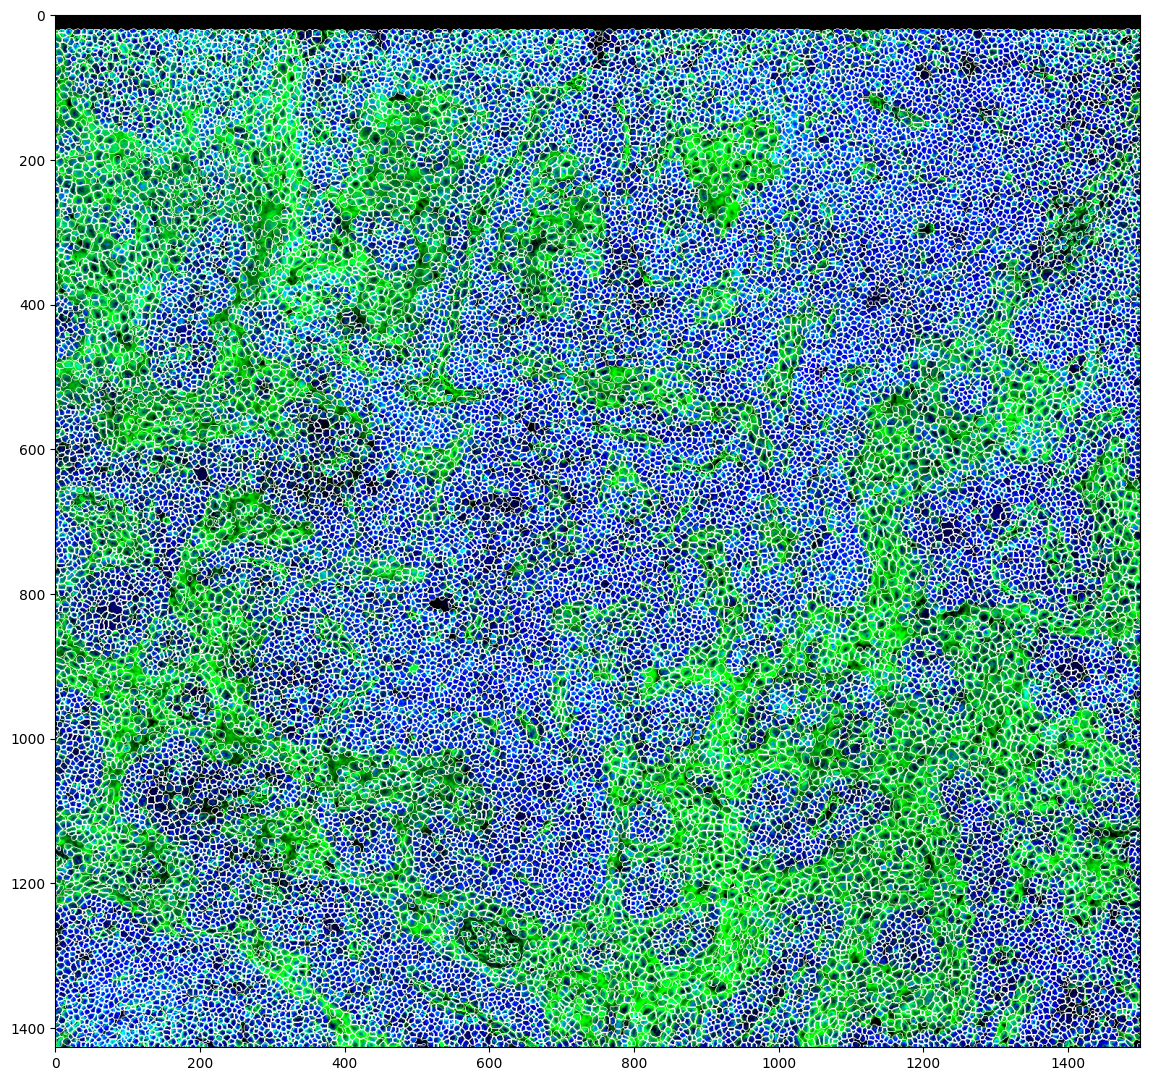

In [7]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov_to_display = io_utils.remove_file_extensions([fovs[8]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)


plt.figure(figsize = (14,14))
plt.imshow(fov_overlay)

In [13]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fovs),
    channels=['nuclear_channel', 'membrane_channel']
)

In [15]:
from PIL import Image
import os

def stitch_tiles(tiles_folder, num_tiles_width, num_tiles_height, tile_width, tile_height, output_filename):
    # Create a blank image with the same size as the original image (based on the number of tiles)
    stitched_image = Image.new('RGB', (num_tiles_width * tile_width, num_tiles_height * tile_height))

    # Iterate over the tiles and paste them into the correct position in the stitched image
    tile_index = 0
    
    for x in range(num_tiles_width):
        for y in range(num_tiles_height):
            # Calculate the position to paste the tile
            left = x * tile_width
            upper = y * tile_height
            tile_path = os.path.join(tiles_folder, f'fov{tile_index}_nuclear_channel_membrane_channel_overlay.tiff')  # Adjust file name if needed
            tile = Image.open(tile_path)

            # Paste the tile at the correct position in the stitched image
            stitched_image.paste(tile, (left, upper))

            tile_index += 1

    # Save the stitched image
    stitched_image.save(tiles_folder+output_filename)

# Example usage
tiles_folder = '../data/LN_/segmentation/deepcell_visualization'
num_tiles_width = 16  # Adjust based on how many tiles in the width
num_tiles_height = 15  # Adjust based on how many tiles in the height
tile_width = 1500  # Width of each tile
tile_height = 1427  # Height of each tile
output_filename = "/stitched_nuc_mem.tif"

stitch_tiles(tiles_folder, num_tiles_width, num_tiles_height, tile_width, tile_height, output_filename)


In [ ]:
from tifffile import imread
image = imread(deepcell_visualization_dir+output_filename)
plt.figure(figsize = (25,25))
plt.imshow(image)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [23]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = True

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [ ]:
fovs = 

In [17]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fovs,
                                              extraction='center_weighting',
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)

# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)